In [1]:
import numpy as np 
from enum import Enum
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
class KernelType(Enum):
    GAUSSIAN = 1
    SQUARE = 2
    EPANECHNIKOV = 3

In [3]:
class NadarayaWatsonRegressor:
    def __init__(self, bandwidth=1, kernel=KernelType.GAUSSIAN):
        if bandwidth <= 0:
            raise ValueError("Bandwidth must be greater than 0")
        
        self.bandwidth = bandwidth
        self.kernel = kernel
        self.mean = 0
        self.x = None
        self.X = None
        self.Y = None

        self.vectorized_func=np.vectorize(self.evaluate_kernel)
    
        if not isinstance(self.kernel, KernelType):
            raise ValueError("Kernel type must be either GAUSSIAN or SQUARE or EPANECHNIKOV")

    def evaluate_kernel(self, value_being_evaluated):
        x=self.x-value_being_evaluated
        x/=self.bandwidth
        if self.kernel == KernelType.GAUSSIAN:
            return np.exp(-0.5 * (x ** 2))/np.sqrt(2 * np.pi)
        elif self.kernel == KernelType.SQUARE:
            return 0.5 * (np.abs(x) <= 1)
        elif self.kernel == KernelType.EPANECHNIKOV:
            return 0.75 * (1 - x ** 2) * (np.abs(x) <= 1)

    def fit(self, X, Y):
        if len(X) != len(Y):
            raise ValueError("X and Y must have the same length")
        self.X = np.array(X)
        self.Y = np.array(Y)
        sorted_indices = np.argsort(self.X)
        self.X = self.X[sorted_indices]
        self.Y = self.Y[sorted_indices]

    def predict(self, x):
        self.x = x
        kernel_results = self.vectorized_func(self.X)
        kernel_sum = np.sum(kernel_results)
        if kernel_sum==0:
            return 0
        return np.sum(kernel_results * self.Y) / kernel_sum

    def fit_and_predict(self, X, Y, x):
        self.fit(X, Y)
        self.predict(x)

    def display(self, bandwidth=None):
        if self.X is None:
            raise NotImplementedError("You must fit the model before displaying it")
        if bandwidth is not None:
            self.bandwidth = bandwidth
        plt.scatter(self.X, self.Y)
        plt.xlim(-1, 4)
        X_vals, Y_predict = self.create_data_to_display(-1, 4)
        plt.plot(X_vals, Y_predict, color='red')
    
    def predict_without_changes(self, i):
        self.x = self.X[i]
        kernel_results = self.vectorized_func(self.X)
        kernel_results[i] = 0
        kernel_sum = np.sum(kernel_results)
        if kernel_sum==0:
            return 0
        return np.sum(kernel_results * self.Y) / kernel_sum
    
    def return_risk(self, bandwidth=None):
        if self.X is None:
            raise NotImplementedError("You must fit the model before calculating the risk")
        if bandwidth is not None:
            self.bandwidth = bandwidth

        n = len(self.X)
        risk = 0

        self.x=0
        weight_i = self.evaluate_kernel(0)
        # print(weight_i)
        y_preds=np.vectorize(self.predict_without_changes)(np.arange(n))
        risk = np.sum((self.Y - y_preds) ** 2)
        risk/=(1-weight_i)**2
        risk/=n
        return risk

    def generate_cross_validator(self, bandwidths=None):
        if bandwidths is None:
            bandwidths=np.linspace(0.01, 2, 200)
        self.bandwidths=bandwidths
        vectorized_return_risk=np.vectorize(self.return_risk)
        self.risks = vectorized_return_risk(bandwidths)

    def plot_cross_validator(self, bandwidths):
        vectorized_return_risk=np.vectorize(self.return_risk)
        self.risks = vectorized_return_risk(bandwidths)
        self.bandwidths=bandwidths
        # print(bandwidths[np.argmin(self.risks)])
        plt.plot(bandwidths, self.risks)

    def create_data_to_display(self, x_lim1, x_lim2):
        X_after_last=np.linspace(np.max(self.X), x_lim2, (x_lim2-int(np.max(self.X)))*1000)
        X_before_first=np.linspace(x_lim1, np.min(self.X), (int(np.min(self.X))-x_lim1)*1000)
        X_vals=np.concatenate((X_before_first, X_after_last))
        Y_vals=np.vectorize(self.predict)(X_vals)
        Y_pred=np.vectorize(self.predict)(self.X)
        X_vals=np.concatenate((X_vals, self.X))
        Y_vals=np.concatenate((Y_vals, Y_pred))
        indices=np.argsort(X_vals)
        X_vals=X_vals[indices]
        Y_vals=Y_vals[indices]
        # print(X_vals, Y_vals)
        return X_vals, Y_vals

    def display_4_plots(self, bandwidth1, bandwidth2, bandwidth3):
        # plt.figure(figsize=(22, 22))
        point_size=15
        facecolor='orange'
        edgecolor='black'
        linewidth=0.5
        x_lim1=-1
        x_lim2=4
        fig, axs = plt.subplots(2, 2)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=3.5)
        fig.subplots_adjust(top=0.88)
        ax1=plt.subplot(2, 2, 1)
        ax1.grid()
        ax1.scatter(self.X, self.Y, s=point_size, edgecolors=edgecolor, facecolor=facecolor, linewidths=linewidth)
        ax1.set_title('Under Smoothened')
        ax1.set_xlim(x_lim1, x_lim2)
        self.bandwidth=bandwidth1
        X_vals, Y_predict=self.create_data_to_display(x_lim1, x_lim2)
        ax1.plot(X_vals, Y_predict, color='red')
        ax1.set_xlabel(f'Bandwidth = {str(round(bandwidth1, 2))}')
        # ax1.set_title("Bandwidth = "+str(bandwidth1))
        ax2=plt.subplot(2, 2, 2)
        ax2.grid()
        ax2.set_title('Over Smoothened')
        ax2.scatter(self.X, self.Y, s=point_size, edgecolors=edgecolor, facecolor=facecolor, linewidths=linewidth)
        ax2.set_xlim(x_lim1, x_lim2)
        self.bandwidth=bandwidth2
        X_vals, Y_predict=self.create_data_to_display(x_lim1, x_lim2)
        ax2.plot(X_vals, Y_predict, color='red')
        ax2.set_xlabel(f'Bandwidth = {str(round(bandwidth2, 2))}')
        # ax2.set_title("Bandwidth = "+str(bandwidth2))
        ax3=plt.subplot(2, 2, 3)
        ax3.grid()
        ax3.set_title('Correctly Smoothened')
        ax3.scatter(self.X, self.Y, s=point_size, edgecolors=edgecolor,facecolor=facecolor, linewidths=linewidth)
        ax3.set_xlim(x_lim1, x_lim2)
        self.bandwidth=bandwidth3
        X_vals, Y_predict=self.create_data_to_display(x_lim1, x_lim2)
        ax3.plot(X_vals, Y_predict, color='red')
        ax3.set_xlabel(f'Bandwidth = {str(round(bandwidth3, 2))}')
        # ax3.set_title("Bandwidth = "+str(bandwidth3))
        ax4=plt.subplot(2, 2, 4)
        ax4.grid()
        ax4.set_title('LOOCV CrossValidation')
        self.generate_cross_validator()
        ax4.plot(self.bandwidths, self.risks)
        ax4.set_xticks(ticks=np.arange(0, 2.1, 0.1))
        ax4.set_xticklabels(labels=[str(round(x, 1)) for x in np.arange(0, 2.1, 0.1)], rotation=45, fontsize=6)
        if self.kernel==KernelType.GAUSSIAN:
            fig.suptitle('KDE using Gaussian Kernel')
            plt.savefig('gaussian_kernel_regression.png')
        elif self.kernel==KernelType.EPANECHNIKOV:
            fig.suptitle('KDE using Epanechnikov Kernel')
            plt.savefig('epanechnikov_kernel_regression.png')
        elif self.kernel==KernelType.SQUARE:
            fig.suptitle('KDE using Tophat Kernel')
            plt.savefig('tophat_kernel_regression.png')

In [4]:
data=pd.read_csv('data.csv')

In [5]:
X=data['Al']

In [6]:
Y=data['RI']

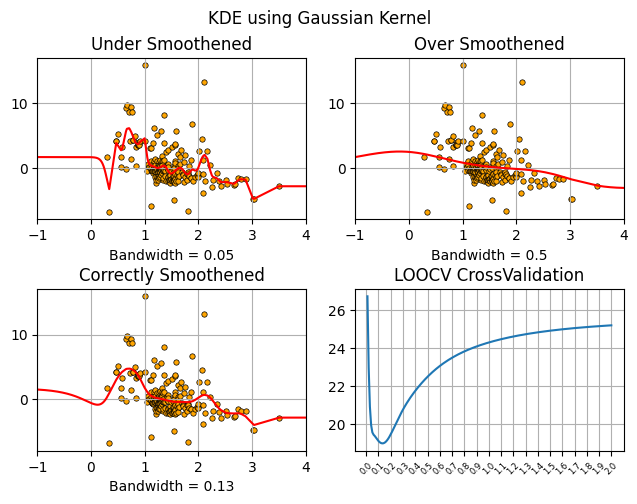

In [7]:
regressor1=NadarayaWatsonRegressor(kernel=KernelType.GAUSSIAN)
regressor1.fit(X, Y)
regressor1.display_4_plots(0.05, 0.5, 0.13)

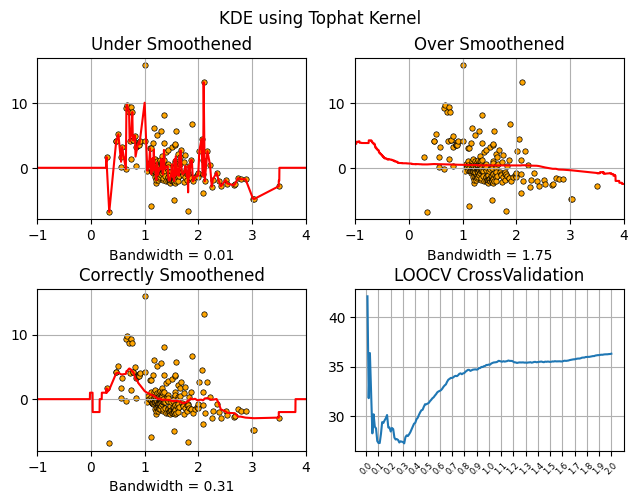

In [8]:
regressor2=NadarayaWatsonRegressor(kernel=KernelType.SQUARE)
regressor2.fit(X, Y)
regressor2.display_4_plots(0.01, 1.75, 0.31)

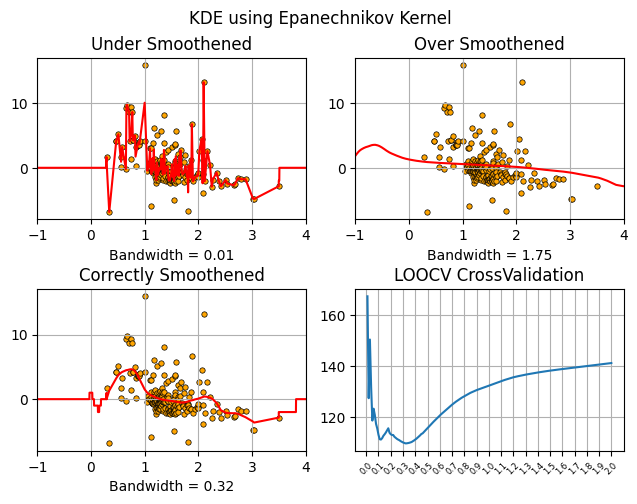

In [9]:
regressor3=NadarayaWatsonRegressor(kernel=KernelType.EPANECHNIKOV)
regressor3.fit(X, Y)
regressor3.display_4_plots(0.01, 1.75, 0.32)